In [7]:
from keras.utils import img_to_array,load_img
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def get_image(path, img_size):
    image = img_to_array(load_img(path, target_size=(img_size, img_size)))
    return image/255.

def get_mask(path, img_size):
    mask = img_to_array(load_img(path, target_size=(img_size, img_size), color_mode='grayscale'))
    mask = tf.cast(mask, tf.uint8)
    return mask


In [5]:
df = pd.read_csv("my_train.csv",index_col="id")
df['organ'] = pd.Categorical(df['organ'], ['prostate', 'spleen', 'lung', 'kidney', 'largeintestine'])
train_df, valid_df, test_df = np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])

In [33]:
img_num = train_df.shape[0]
img_size = 512

def get_arrays(df,img_size):
    img_num = df.shape[0]
    image_dir = './images_png'
    mask_dir = './masks_png'
    input_images = np.zeros(shape=(img_num, img_size, img_size, 3), dtype='float32')
    input_masks = np.zeros(shape=(img_num, img_size, img_size, 1), dtype='uint8')
    for i in range(img_num):
        input_images[i, :, :, :] = get_image(os.path.join(image_dir,str(df.iloc[i].name)+'.png'), img_size)
        input_masks[i, :, :, :] = get_mask(os.path.join(mask_dir,str(df.iloc[i].name)+'.png'), img_size)
    return input_images,input_masks


In [36]:
x_train, y_train = get_arrays(train_df,img_size)
x_valid, y_valid = get_arrays(valid_df,img_size)
x_test, y_test = get_arrays(test_df,img_size)

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

# smaller network
tf.keras.backend.clear_session()
def get_model(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)
    model = keras.Model(inputs, outputs)
    return model

    
model = get_model(img_size, 1)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       147584

In [39]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=30), keras.callbacks.ModelCheckpoint('mymodel', save_best_only=True)]
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), batch_size=4, callbacks=callbacks)

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 8.7383 - accuracy: 0.8956

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


70/70 [==============================] - 255s 4s/step - loss: 8.7383 - accuracy: 0.8956 - val_loss: 0.3167 - val_accuracy: 0.8853
Epoch 2/10
70/70 [==============================] - 228s 3s/step - loss: 0.7739 - accuracy: 0.9039 - val_loss: 0.3259 - val_accuracy: 0.8853
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.9039

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


70/70 [==============================] - 224s 3s/step - loss: 0.3094 - accuracy: 0.9039 - val_loss: 0.3164 - val_accuracy: 0.8853
Epoch 4/10
70/70 [==============================] - 221s 3s/step - loss: 0.4042 - accuracy: 0.9039 - val_loss: 0.3905 - val_accuracy: 0.8853
Epoch 5/10
70/70 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.9039

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


70/70 [==============================] - 217s 3s/step - loss: 0.3279 - accuracy: 0.9039 - val_loss: 0.3118 - val_accuracy: 0.8853
Epoch 6/10
70/70 [==============================] - 211s 3s/step - loss: 0.3026 - accuracy: 0.9039 - val_loss: 0.3354 - val_accuracy: 0.8853
Epoch 7/10
70/70 [==============================] - 223s 3s/step - loss: 0.2947 - accuracy: 0.9039 - val_loss: 0.3222 - val_accuracy: 0.8853
Epoch 8/10
70/70 [==============================] - 222s 3s/step - loss: 0.2950 - accuracy: 0.9039 - val_loss: 0.3151 - val_accuracy: 0.8853
Epoch 9/10
70/70 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9039

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


70/70 [==============================] - 225s 3s/step - loss: 0.2912 - accuracy: 0.9039 - val_loss: 0.3064 - val_accuracy: 0.8853
Epoch 10/10
70/70 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.9039

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


70/70 [==============================] - 228s 3s/step - loss: 0.2894 - accuracy: 0.9039 - val_loss: 0.2963 - val_accuracy: 0.8853


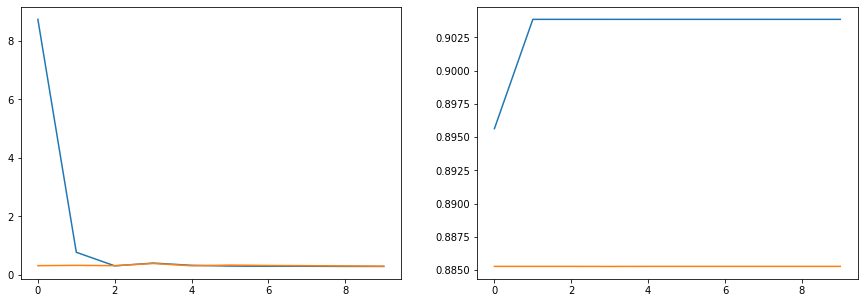

In [41]:
import matplotlib.pyplot as plt
fig, (ax_loss, ax_accu) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_accu.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_accu.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")